# GAN MLP MNIST

This notebook is for implementing `Generative Adversarial Network(GAN)` with [Tensorflow](https://www.tensorflow.org). <br>
Network architecture will be `Multi-layer perceptron` and [MNIST data](http://yann.lecun.com/exdb/mnist/) will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os

## Parameters


In [3]:
algorithm = 'GAN'

img_size   = 28
data_size  = img_size**2

batch_size = 256
num_epoch  = 150

n_hidden = 256
n_latent = 100

learning_rate_g = 2e-4
learning_rate_d = 2e-4

show_result_epoch = 5

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_CycleGAN_Horse2Zebra/model/model" 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

x_train = np.reshape(x_train, [-1, data_size])
x_test  = np.reshape(x_test, [-1, data_size])

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 784)
y_train shape: (60000,)
x_test shape: (10000, 784)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # First hidden layer
        w1 = tf.get_variable('w1', [x.get_shape()[1], n_hidden], initializer=xavier_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=xavier_init)

        h1 = tf.nn.leaky_relu(tf.matmul(x,w1)+b1)   
        
        # Second hidden layer
        w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=xavier_init)
        b2 = tf.get_variable('b2', [n_hidden], initializer=xavier_init)

        h2 = tf.nn.leaky_relu(tf.matmul(h1,w2)+b2)   
        
        # Output layer
        w3 = tf.get_variable('w3', [h2.get_shape()[1], data_size], initializer=xavier_init)      
        b3 = tf.get_variable('b3', [data_size], initializer=xavier_init)
        
        output = tf.sigmoid(tf.matmul(h2, w3)+b3)
        
        return output

## Discriminator

In [7]:
def Discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First hidden layer
        w1 = tf.get_variable('w1', [x.get_shape()[1], n_hidden], initializer=xavier_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=xavier_init)

        h1 = tf.nn.leaky_relu(tf.matmul(x,w1)+b1)
        
        # Second hidden layer
        w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=xavier_init)
        b2 = tf.get_variable('b2', [n_hidden], initializer=xavier_init)

        h2 = tf.nn.leaky_relu(tf.matmul(h1,w2)+b2)
              
        # Output layer
        wo = tf.get_variable('wo', [h2.get_shape()[1], 1], initializer=xavier_init)      
        bo = tf.get_variable('bo', [1], initializer=xavier_init)      
        
        logit = tf.matmul(h2, wo)+bo
        output = tf.sigmoid(logit)

        return logit, output

## GAN

In [8]:
def GAN(x, z):
    # Generator
    G = Generator(z)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x)
    D_logit_fake, D_out_fake = Discriminator(G, reuse=True)
    
    # get loss
    d_loss = -(tf.reduce_mean(tf.log(D_out_real + 1e-8)) + tf.reduce_mean(tf.log( (1-D_out_fake) + 1e-8)))
    g_loss = -tf.reduce_mean(tf.log(D_out_fake + 1e-8))

    return d_loss, g_loss , G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, data_size])
x_normalize = (tf.cast(x, tf.float32)) / (255.0)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, z) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [ ]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / G Loss: 6.67235 / D Loss: 0.04604


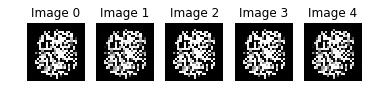

Epoch: 2 / G Loss: 8.00006 / D Loss: 0.02887
Epoch: 3 / G Loss: 8.76780 / D Loss: 0.00048
Epoch: 4 / G Loss: 8.06859 / D Loss: 0.00077
Epoch: 5 / G Loss: 9.17308 / D Loss: 0.00073


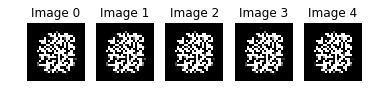

Epoch: 6 / G Loss: 8.68714 / D Loss: 0.00098
Epoch: 7 / G Loss: 9.28557 / D Loss: 0.00015
Epoch: 8 / G Loss: 7.66794 / D Loss: 0.00209
Epoch: 9 / G Loss: 9.78227 / D Loss: 0.00094
Epoch: 10 / G Loss: 11.19008 / D Loss: 0.00920


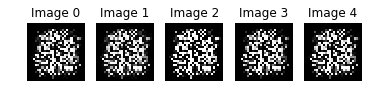

Epoch: 11 / G Loss: 10.12480 / D Loss: 0.00069
Epoch: 12 / G Loss: 10.29093 / D Loss: 0.00061
Epoch: 13 / G Loss: 8.70315 / D Loss: 0.00108
Epoch: 14 / G Loss: 9.17738 / D Loss: 0.00197
Epoch: 15 / G Loss: 9.82064 / D Loss: 0.00207


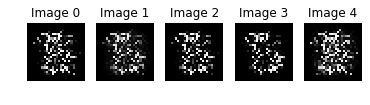

Epoch: 16 / G Loss: 10.71913 / D Loss: 0.00036
Epoch: 17 / G Loss: 11.19013 / D Loss: 0.00034
Epoch: 18 / G Loss: 8.32104 / D Loss: 0.00170
Epoch: 19 / G Loss: 11.98552 / D Loss: 0.00083
Epoch: 20 / G Loss: 12.25039 / D Loss: 0.00038


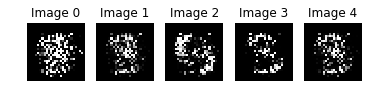

Epoch: 21 / G Loss: 11.14770 / D Loss: 0.01826
Epoch: 22 / G Loss: 13.21797 / D Loss: 0.00103
Epoch: 23 / G Loss: 9.02286 / D Loss: 0.00356
Epoch: 24 / G Loss: 9.68970 / D Loss: 0.00270
Epoch: 25 / G Loss: 9.61295 / D Loss: 0.00727


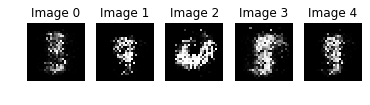

Epoch: 26 / G Loss: 12.50169 / D Loss: 0.02954
Epoch: 27 / G Loss: 11.21773 / D Loss: 0.00128
Epoch: 28 / G Loss: 11.04549 / D Loss: 0.00533
Epoch: 29 / G Loss: 11.58339 / D Loss: 0.00706
Epoch: 30 / G Loss: 11.26721 / D Loss: 0.00632


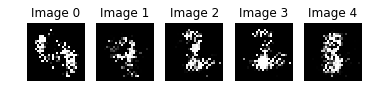

Epoch: 31 / G Loss: 11.59486 / D Loss: 0.00445
Epoch: 32 / G Loss: 9.30791 / D Loss: 0.02535
Epoch: 33 / G Loss: 8.42685 / D Loss: 0.00695
Epoch: 34 / G Loss: 11.42566 / D Loss: 0.00145
Epoch: 35 / G Loss: 10.75725 / D Loss: 0.00722


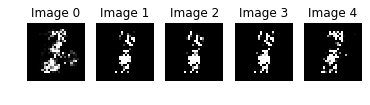

Epoch: 36 / G Loss: 12.75472 / D Loss: 0.00050
Epoch: 37 / G Loss: 12.27736 / D Loss: 0.00807
Epoch: 38 / G Loss: 8.92298 / D Loss: 0.01513
Epoch: 39 / G Loss: 10.59778 / D Loss: 0.04898
Epoch: 40 / G Loss: 9.86501 / D Loss: 0.00546


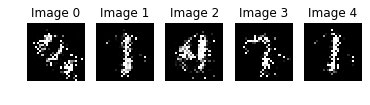

Epoch: 41 / G Loss: 11.10253 / D Loss: 0.00186
Epoch: 42 / G Loss: 13.24591 / D Loss: 0.03297
Epoch: 43 / G Loss: 12.66667 / D Loss: 0.00066
Epoch: 44 / G Loss: 8.62557 / D Loss: 0.01842
Epoch: 45 / G Loss: 11.94641 / D Loss: 0.03305


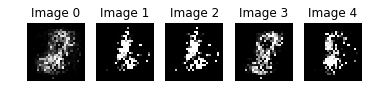

Epoch: 46 / G Loss: 14.02052 / D Loss: 0.06527
Epoch: 47 / G Loss: 10.61342 / D Loss: 0.03846
Epoch: 48 / G Loss: 12.30398 / D Loss: 0.08951
Epoch: 49 / G Loss: 9.69384 / D Loss: 0.00660
Epoch: 50 / G Loss: 8.66619 / D Loss: 0.02525


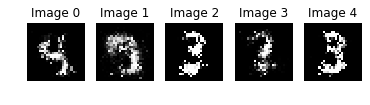

Epoch: 51 / G Loss: 10.54139 / D Loss: 0.00408
Epoch: 52 / G Loss: 9.99116 / D Loss: 0.00464
Epoch: 53 / G Loss: 9.18219 / D Loss: 0.01391
Epoch: 54 / G Loss: 9.69375 / D Loss: 0.02699
Epoch: 55 / G Loss: 9.52885 / D Loss: 0.02063


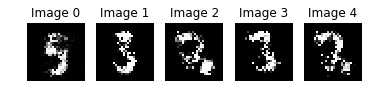

Epoch: 56 / G Loss: 8.09355 / D Loss: 0.09195
Epoch: 57 / G Loss: 8.30151 / D Loss: 0.07570
Epoch: 58 / G Loss: 7.69339 / D Loss: 0.03207
Epoch: 59 / G Loss: 6.67812 / D Loss: 0.04719
Epoch: 60 / G Loss: 6.43709 / D Loss: 0.04125


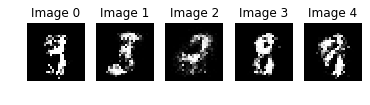

Epoch: 61 / G Loss: 6.80036 / D Loss: 0.16943
Epoch: 62 / G Loss: 7.41015 / D Loss: 0.13979
Epoch: 63 / G Loss: 6.92441 / D Loss: 0.09361
Epoch: 64 / G Loss: 6.77877 / D Loss: 0.15114
Epoch: 65 / G Loss: 6.42998 / D Loss: 0.17788


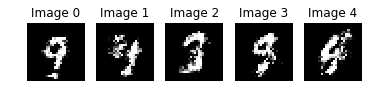

Epoch: 66 / G Loss: 6.91963 / D Loss: 0.08800
Epoch: 67 / G Loss: 4.88726 / D Loss: 0.12640
Epoch: 68 / G Loss: 5.26380 / D Loss: 0.17082
Epoch: 69 / G Loss: 5.88291 / D Loss: 0.12115
Epoch: 70 / G Loss: 5.26559 / D Loss: 0.12216


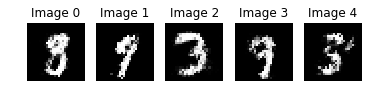

Epoch: 71 / G Loss: 5.65261 / D Loss: 0.20106
Epoch: 72 / G Loss: 6.01813 / D Loss: 0.06644
Epoch: 73 / G Loss: 5.43242 / D Loss: 0.17817
Epoch: 74 / G Loss: 5.36827 / D Loss: 0.10921
Epoch: 75 / G Loss: 5.84803 / D Loss: 0.21597


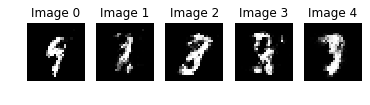

Epoch: 76 / G Loss: 5.08403 / D Loss: 0.11638
Epoch: 77 / G Loss: 4.94116 / D Loss: 0.26326
Epoch: 78 / G Loss: 4.43049 / D Loss: 0.13590
Epoch: 79 / G Loss: 3.59281 / D Loss: 0.35211
Epoch: 80 / G Loss: 5.05556 / D Loss: 0.21379


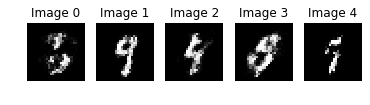

Epoch: 81 / G Loss: 4.41556 / D Loss: 0.33797
Epoch: 82 / G Loss: 4.48325 / D Loss: 0.27858
Epoch: 83 / G Loss: 5.20034 / D Loss: 0.32856
Epoch: 84 / G Loss: 4.81890 / D Loss: 0.25065
Epoch: 85 / G Loss: 4.35934 / D Loss: 0.22426


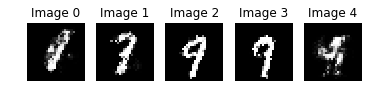

Epoch: 86 / G Loss: 4.23953 / D Loss: 0.26126
Epoch: 87 / G Loss: 4.88443 / D Loss: 0.27263
Epoch: 88 / G Loss: 4.58550 / D Loss: 0.22743
Epoch: 89 / G Loss: 4.20046 / D Loss: 0.21780
Epoch: 90 / G Loss: 4.26139 / D Loss: 0.22009


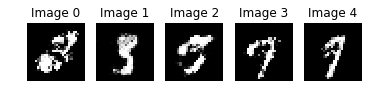

Epoch: 91 / G Loss: 4.47031 / D Loss: 0.17267
Epoch: 92 / G Loss: 5.07402 / D Loss: 0.26285
Epoch: 93 / G Loss: 3.52038 / D Loss: 0.28020
Epoch: 94 / G Loss: 3.80650 / D Loss: 0.39200
Epoch: 95 / G Loss: 3.60964 / D Loss: 0.28431


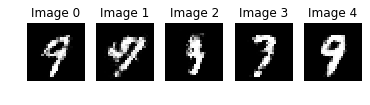

Epoch: 96 / G Loss: 3.72615 / D Loss: 0.24692
Epoch: 97 / G Loss: 3.65713 / D Loss: 0.31691
Epoch: 98 / G Loss: 3.52077 / D Loss: 0.34192
Epoch: 99 / G Loss: 3.76807 / D Loss: 0.40834
Epoch: 100 / G Loss: 3.67998 / D Loss: 0.36006


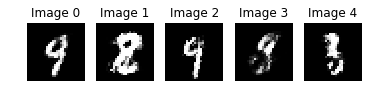

Epoch: 101 / G Loss: 3.71948 / D Loss: 0.23953
Epoch: 102 / G Loss: 3.80904 / D Loss: 0.33212
Epoch: 103 / G Loss: 3.42375 / D Loss: 0.35181
Epoch: 104 / G Loss: 3.56343 / D Loss: 0.33837
Epoch: 105 / G Loss: 3.43458 / D Loss: 0.27922


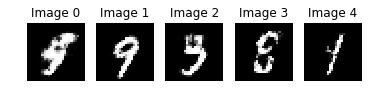

Epoch: 106 / G Loss: 3.62017 / D Loss: 0.40772
Epoch: 107 / G Loss: 3.28994 / D Loss: 0.47482
Epoch: 108 / G Loss: 3.16717 / D Loss: 0.33410
Epoch: 109 / G Loss: 2.89289 / D Loss: 0.59633
Epoch: 110 / G Loss: 2.76782 / D Loss: 0.63264


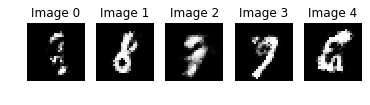

Epoch: 111 / G Loss: 2.97070 / D Loss: 0.43250
Epoch: 112 / G Loss: 3.49191 / D Loss: 0.47944
Epoch: 113 / G Loss: 3.48494 / D Loss: 0.44871
Epoch: 114 / G Loss: 3.49943 / D Loss: 0.34984
Epoch: 115 / G Loss: 2.71638 / D Loss: 0.38446


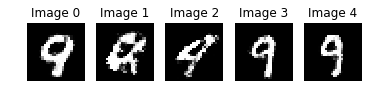

Epoch: 116 / G Loss: 3.45061 / D Loss: 0.47355
Epoch: 117 / G Loss: 3.48235 / D Loss: 0.46563
Epoch: 118 / G Loss: 3.10297 / D Loss: 0.38178
Epoch: 119 / G Loss: 3.20176 / D Loss: 0.42922
Epoch: 120 / G Loss: 3.47643 / D Loss: 0.33566


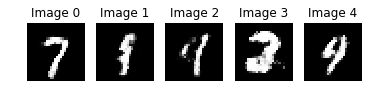

Epoch: 121 / G Loss: 2.87837 / D Loss: 0.35164
Epoch: 122 / G Loss: 2.93415 / D Loss: 0.43168
Epoch: 123 / G Loss: 2.72580 / D Loss: 0.49909
Epoch: 124 / G Loss: 3.22514 / D Loss: 0.37010
Epoch: 125 / G Loss: 2.74655 / D Loss: 0.59140


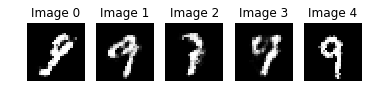

Epoch: 126 / G Loss: 2.23377 / D Loss: 0.54434
Epoch: 127 / G Loss: 2.56489 / D Loss: 0.49231
Epoch: 128 / G Loss: 2.51639 / D Loss: 0.61378
Epoch: 129 / G Loss: 2.93069 / D Loss: 0.40005
Epoch: 130 / G Loss: 3.02428 / D Loss: 0.45549


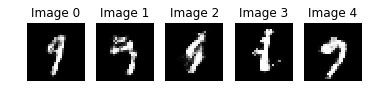

Epoch: 131 / G Loss: 2.58594 / D Loss: 0.49273
Epoch: 132 / G Loss: 2.83252 / D Loss: 0.47270
Epoch: 133 / G Loss: 2.82994 / D Loss: 0.33703
Epoch: 134 / G Loss: 2.82337 / D Loss: 0.50046
Epoch: 135 / G Loss: 2.76491 / D Loss: 0.42704


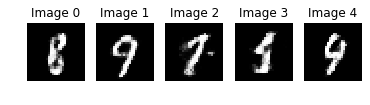

Epoch: 136 / G Loss: 2.44113 / D Loss: 0.58643
Epoch: 137 / G Loss: 2.78043 / D Loss: 0.50638
Epoch: 138 / G Loss: 2.93066 / D Loss: 0.56899
Epoch: 139 / G Loss: 2.72635 / D Loss: 0.45649
Epoch: 140 / G Loss: 2.32083 / D Loss: 0.45475


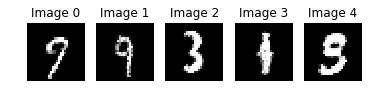

Epoch: 141 / G Loss: 2.54252 / D Loss: 0.42625
Epoch: 142 / G Loss: 2.51941 / D Loss: 0.40433
Epoch: 143 / G Loss: 2.82983 / D Loss: 0.51171
Epoch: 144 / G Loss: 2.20074 / D Loss: 0.45445
Epoch: 145 / G Loss: 2.45398 / D Loss: 0.51286


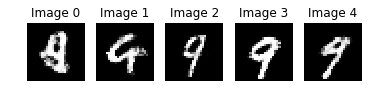

Epoch: 146 / G Loss: 2.22986 / D Loss: 0.49986
Epoch: 147 / G Loss: 2.46172 / D Loss: 0.46607
Epoch: 148 / G Loss: 2.88607 / D Loss: 0.48938
Epoch: 149 / G Loss: 2.57252 / D Loss: 0.41396
Epoch: 150 / G Loss: 2.36961 / D Loss: 0.42403


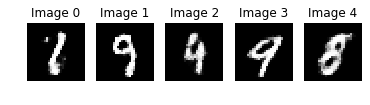

In [11]:
if train_model:
    # Training
    data_x = x_train
    len_data = x_train.shape[0]

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(data_x)

        # Making mini-batch
        for j in range(0, len_data, batch_size):
            if j + batch_size < len_data:
                data_x_in = data_x[j : j + batch_size, :]
            else:
                data_x_in = data_x[j : len_data, :]

            sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))

            # Run Optimizer!
            _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, z: sampled_z})
            _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, z: sampled_z})

            print("Batch: {} / {}".format(j, len_data), end="\r")

        # Print Progess
        print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))

        # Show test images 
        z_test = np.random.uniform(-1, 1, size=(5, n_latent))
        G_out = sess.run(G, feed_dict = {z: z_test})
        output_reshape = np.reshape(G_out, [5, img_size, img_size])

        if i == 0 or (i+1) % show_result_epoch == 0:
            f, ax = plt.subplots(1,5)
            for j in range(5):
                ax[j].imshow(output_reshape[j,:,:], cmap = 'gray')
                ax[j].axis('off')
                ax[j].set_title('Image '+str(j))

        plt.show()

## Image Generation

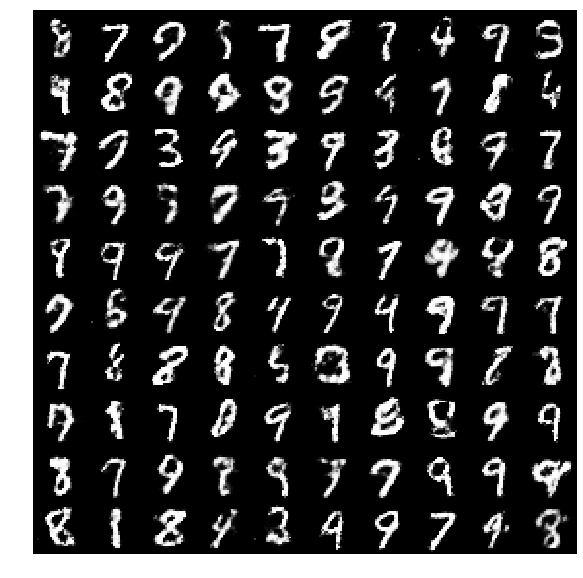

In [12]:
num_test = 10

img = np.zeros([img_size * num_test, img_size * num_test])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(G, feed_dict = {z: z_result})
output_reshape = np.reshape(G_result, [num_test**2, img_size, img_size])

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = output_reshape[i,:,:]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))